In [3]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns

## Define an option class
 inheritance of the call and put options

In [4]:
class option:
    def __init__(self,vol,matu,strike,spot,rate):
        self.sigma = vol
        self.T= matu
        self.K= strike
        self.S0 = spot
        self.r = rate
class call(option):
    def __init__(self,vol,matu,strike,spot,rate):
        option.__init__(self,vol,matu,strike,spot,rate)
        self.payoff="call"
class put(option):
    def __init__(self,vol,matu,strike,spot,rate):
        option.__init__(self,vol,matu,strike,spot,rate)
        self.payoff = "put"

### Define 2 useful functions:
 * bs_price : compute the price of an option
 * vega : vega of an option 

In [5]:
N=lambda x: scipy.stats.norm.cdf(x,0,1)

def bs_price(S0,K,r,sigma,T,payoff):
    d1 = (np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Call_price = S0*N(d1)-K*np.exp(-r*T)*N(d2)
    if payoff == "call": return Call_price
    if payoff =="put": return Call_price-S0+K*np.exp(-r*T)

def vega(S0,K,r,sigma,T,payoff):
    d1 = (np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    return S0*np.sqrt(T)*norm.pdf(d1)

### Import data
 * We take 1 year maturity call options on SPX

In [6]:
data_spx = pd.read_csv("spx_1y_call.csv")
del data_spx["Ticker"]

spot = 4380.26

data_spx["Strike"]/=spot/100
data_spx=data_spx.set_index(["Strike"])
data_spx["Bid"]/=spot/100,
data_spx["Ask"]/=spot/100

### Define the function which we want to find roots using Newton-Raphson method
This function is a function of $\sigma$ : $f(\sigma) = P_{BS(\sigma)}-P_{market}$ \
To ease list comprehension, we add strike and market price arguments

In [7]:
def vol_diff(vol,K,p0):
    return bs_price(S0,K,r,vol,T,payoff="call")-p0

### We test this method using Scipy's included function "optimize.newton"
Although it's more convenient and shorter, it only works for the 12 first strikes..

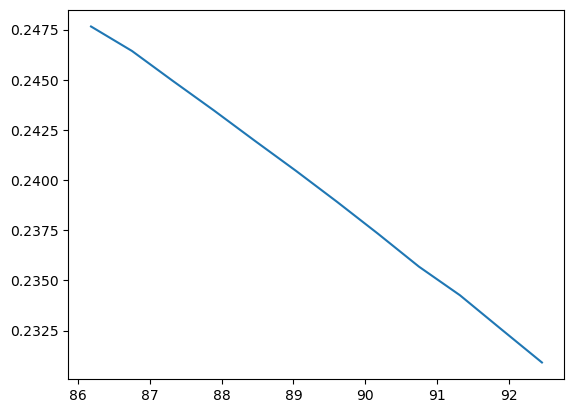

In [8]:
r=0.01225
T=1
S0=100

strikes=data_spx.index.values
prices=data_spx["Bid"].values

sigmas = np.array([scipy.optimize.newton(vol_diff,0.05,args=(strikes[i],prices[i],),maxiter=150) for i in range(12)])
plt.plot(strikes[:12],sigmas)
plt.show()

# Using a tailor made Newton Raphson function

## Define our Newton-Raphson function

In [9]:
def newton_raphson_vol(S0,K,r,T,p0,vol0,eps, max_iter, payoff="call"):
    sigma = vol0
    diff = bs_price(S0,K,r,sigma,T,payoff)-p0
    x1=vol0-diff/vega(S0,K,r,sigma,T,payoff)

    for i in range(max_iter):
        sigma=x1
        diff = bs_price(S0,K,r,sigma,T,payoff)-p0
        x1=x1-diff/vega(S0,K,r,sigma,T,payoff)
        if abs(bs_price(S0,K,r,sigma,T,payoff)-p0) < eps: return x1
    return x1

### Set new tests

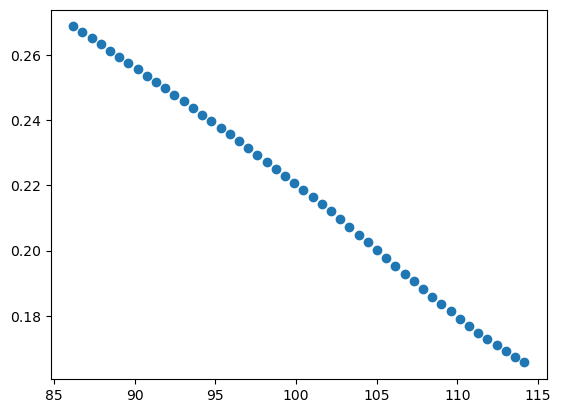

In [10]:
r=0.001225
T=1
S0=100
sigmas_bis = np.array([newton_raphson_vol(S0,K=strikes[i],r=r,T=T,p0=prices[i],vol0=0.2,eps=0.0001, max_iter=100, payoff="call") for i in range(50)])

plt.clf()
plt.plot(strikes,sigmas_bis,'o')
plt.show()


### We can see that there seems to be skew, but it's not obvious. we will try to use shorter maturity options

### Initialize data for 3M options

In [27]:
data_3m = pd.read_csv("spx_3m_call.csv")
data_3m["Strike"] /= spot/100
data_3m["Bid"] /= spot/100
data_3m["Ask"]/=spot/100

data_3m = data_3m.set_index(["Strike"])
data_3m.head()
r=0.001225
T2=1/3
S0=100

strikes2=data_3m.index.values
prices2=data_3m["Bid"].values

# Results are a bit clearer.

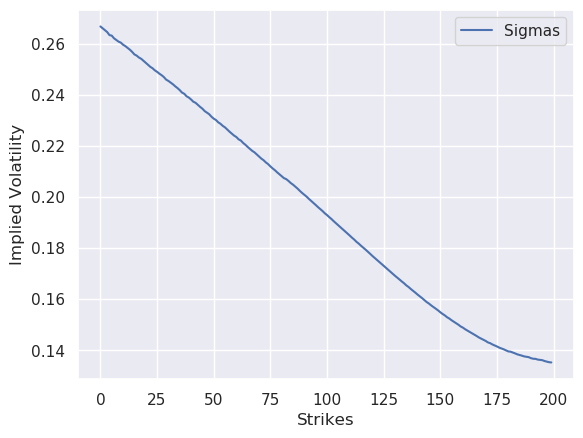

In [28]:
sigmas_ter = np.array([newton_raphson_vol(S0,K=strikes2[i],r=r,T=T2,p0=prices2[i],vol0=0.2,eps=0.0001, max_iter=100, payoff="call") for i in range(200)])

sns.set()
plt.clf()
p = sns.lineplot(data=pd.DataFrame({"Sigmas":sigmas_ter}))
plt.xlabel("Strikes")
plt.ylabel("Implied Volatility")
plt.show()



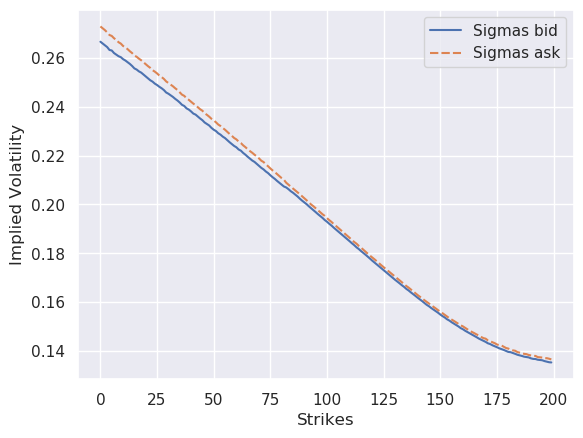

In [36]:
#same for ask

data_3m.head()
prices_ask = data_3m["Ask"].values
sigmas_ask = np.array([newton_raphson_vol(S0,K=strikes2[i],r=r,T=T2,p0=prices_ask[i],vol0=0.2,eps=0.0001, max_iter=100, payoff="call") for i in range(200)])

sns.set()
plt.clf()
p = sns.lineplot(data=pd.DataFrame({"Sigmas bid":sigmas_ter, "Sigmas ask": sigmas_ask}))
#ccc=pd.DataFrame({"Sigmas bid":sigmas_ter, "Sigmas ask": sigmas_ask})
#ccc.head()
plt.xlabel("Strikes")
plt.ylabel("Implied Volatility")
plt.show()

## We can plot the volatility spread

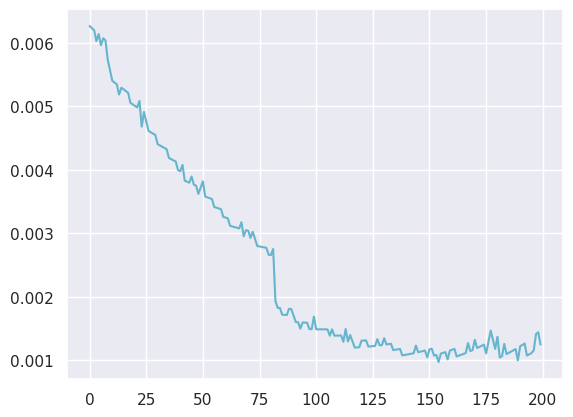

In [35]:
spread=sigmas_ask-sigmas_ter
plt.clf()
plt.plot(spread,'c')
plt.show()